# Instruction

This is a simple and complete example of natural language processing. We use companies' year reports(10K) as raw data to construct the sentiment vectors of these report. In addition options, we can add 10Q or hafl year report into download list.

We supposed that the thickers return will growth stable if each year of sentiments are similarity. We just make up this hypothesis as an factor and verify it.

This project process include:
1. Use reqests to load 10k data
2. Clean data steps contains regex, BeatifulSoup, tokenize(and lemmontize if in english), bag of words
3. Extract sentiment vector by tf-idf 
4. Get factors by comparing two adjacent sentiment vectors in cosine similarity and jaccard methods
5. Estimate performance of the factor by alphalens

## Load Package

In [1]:
import pprint
import pandas as pd
import numpy as np
import pkuseg

from cnsenti import Sentiment
from tqdm import tqdm
from collections import defaultdict

from bs4 import BeautifulSoup
import requests
import re
import time

In [ ]:
# Down load all support language but there is no chinese
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

## Download Data
We download links of 10ks and 10qs from https://finance.sina.com.cn/.
We request a home page and parse it by Beautiful soup to get links.

In [11]:
def _concat_navigate_link(tickers):
    '''
    param: str list
    return: Datefram
        colmns is tickers, values is links of navigating
    '''
    
    # nagigate_link links to each time report (season1, half_year, season3, year)
    navigate_links = [
                #'https://vip.stock.finance.sina.com.cn/corp/go.php/vCB_BulletinYi/stockid/{}/page_type/yjdbg.phtml',
                'https://vip.stock.finance.sina.com.cn/corp/go.php/vCB_BulletinZhong/stockid/{}/page_type/zqbg.phtml',
                #'https://vip.stock.finance.sina.com.cn/corp/go.php/vCB_BulletinSan/stockid/{}/page_type/sjdbg.phtml',
                'https://vip.stock.finance.sina.com.cn/corp/go.php/vCB_Bulletin/stockid/{}/page_type/ndbg.phtml'
            ]

    # concat all links
    ticker_navigate_link = {}
    for ticker in tickers:
        ticker_navigate_link[ticker] = []
        for navigate_link in navigate_links:
            ticker_navigate_link[ticker].append(navigate_link.format(ticker[:6]))

    ticker_navigate_link = pd.DataFrame(ticker_navigate_link)

    return ticker_navigate_link

def _download_reports_by_navigate(link, ticker):
    '''
        param: link(str)
            a navigate link to the navigate page to got complete links to reports
        param: ticker(str)
            the ticker name
            
        return:(Dateframe)
            download each link and construct a Dateframe
            index is date time, value is download report page content
    '''
    
    headers = {
        'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36'
    }
    
    # one navigate link got all times to report link
    r = requests.get(link, headers=headers)
    page_content = BeautifulSoup(r.text, 'lxml')
    html_text = page_content.find_all('div', class_='datelist')[0].findAll('ul')

    # got all times
    regex = re.compile(r'\d{4}-\d{2}-\d{2}')
    date_list = regex.findall(html_text[0].get_text())

    # got all links
    tags_a = html_text[0].findAll('a')
    reports_list = []
    for tag_a, date_i in tqdm(zip(tags_a, date_list), desc=ticker):
        # ignore duplicate data
        if '（英文版）' in tag_a.get_text() \
        or '（已取消）' in tag_a.get_text() \
        or '（修订版）' in tag_a.get_text():
            continue
        # download
        down_load_link = 'https://vip.stock.finance.sina.com.cn'+tag_a.attrs['href']
        report_resp = requests.get(down_load_link, headers=headers)
        # clean data filter keep content tag
        page_content = BeautifulSoup(report_resp.text, 'lxml')
        html_text = page_content.findAll('div', class_='graybgH2')[0].findAll('div', id='content')
        if len(html_text[0].get_text())>10000:
            reports_list.append([date_i, tag_a.get_text() , html_text])
        else:
            print(f'{ticker} in {date_i} data download failed, check out data source!')
        time.sleep(0.5)
        
    df = pd.DataFrame(reports_list, columns=['file_date', 'file_name', '10Q_html'])
    df['ts_code'] = ticker
    
    return df

def download_reports_by_ticker(tickers):
    '''
    param: all tickers as ts_code lists
    return: Dateframe
        columns is tickers, index is date (Y-M-D)
    '''
    navi_df = _concat_navigate_link(tickers)
    df = pd.DataFrame()
    for ticker in navi_df.columns:
        for navi_link in navi_df[ticker]:
            df = df.append(_download_reports_by_navigate(navi_link, ticker))
            
    return df
    

In [14]:
# 一品红、新华制药、美诺华、圣诺生物、华纳药厂
# 恒瑞医药、泰格医药、北陆药业、赛升药业
tickers =['300723.SZ', '000756.SZ', '603538.SH', '688117.SH', '688799.SH', 
         '600276.SH', '300347.SZ', '300016.SZ', '300485.SZ']

#tickers = ['603538.SH']
all_reports_df = download_reports_by_ticker(tickers)

300723.SZ: 6it [00:07,  1.20s/it]
300723.SZ: 6it [00:09,  1.54s/it]
000756.SZ: 10it [00:09,  1.02it/s]
000756.SZ: 10it [00:09,  1.01it/s]
603538.SH: 6it [00:06,  1.08s/it]
603538.SH: 5it [00:05,  1.16s/it]
688117.SH: 2it [00:02,  1.20s/it]
688117.SH: 1it [00:01,  1.27s/it]
688799.SH: 2it [00:02,  1.22s/it]
688799.SH: 1it [00:03,  3.91s/it]
600276.SH: 7it [00:07,  1.10it/s]

600276.SH in 2015-08-25 data download failed, check out data source!


600276.SH: 10it [00:09,  1.07it/s]
600276.SH: 10it [00:09,  1.05it/s]
300347.SZ: 10it [00:09,  1.04it/s]
300347.SZ: 10it [00:08,  1.16it/s]
300016.SZ: 10it [00:09,  1.04it/s]
300016.SZ: 10it [00:09,  1.01it/s]
300485.SZ: 10it [00:13,  1.34s/it]
300485.SZ: 9it [00:07,  1.13it/s]


In [15]:
# save data to file 
all_reports_df.to_csv('all_reports_raw.csv')
all_reports_df

,file_date,file_name,10Q_html,ts_code
0,2022-07-29,一品红：2022年半年度报告,"[[\n, [一品红药业股份有限公司], [2022年半年度报告], [2022-079],...",300723.SZ
1,2021-07-30,一品红：2021年半年度报告,"[[\n, [一品红药业股份有限公司], [2021], [年半年度报告], [2021-1...",300723.SZ
2,2020-08-28,一品红：2020年半年度报告,"[[\n, [一品红药业股份有限公司], [2020年半年度报告], [2020-067],...",300723.SZ
3,2019-08-16,一品红：2019年半年度报告,"[[\n, [一品红药业股份有限公司], [2019年半年度报告], [2019-070],...",300723.SZ
4,2019-08-12,一品红：2018年半年度报告（更新后）,"[[\n, [一品红药业股份有限公司], [2018年半年度报告], [2018-072],...",300723.SZ
...,...,...,...,...
3,2019-03-28,赛升药业：2018年年度报告,"[[\n, [北京赛升药业股份有限公司], [2018年年度报告], [2019-008],...",300485.SZ
4,2018-03-16,赛升药业：2017年年度报告（更新后）,"[[\n, [北京赛升药业股份有限公司 2017 年年度报告全文\r\n北京赛升药业股份有限...",300485.SZ
5,2018-03-15,赛升药业：2017年年度报告,"[[\n, [北京赛升药业股份有限公司 2017 年年度报告全文\r\n北京赛升药业股份有限...",300485.SZ
6,2017-04-26,赛升药业：2016年年度报告,"[[\n, [北京赛升药业股份有限公司 2016 年年度报告全文\r\n北京赛升药业股份有限...",300485.SZ


## Load Data from File

In [225]:
## if use nltk fist, you should excute this module
# Down load all support language
#import nltk
#nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('words')

In [2]:
import pprint
import pandas as pd
import numpy as np
import pkuseg

from cnsenti import Sentiment
from tqdm import tqdm
from collections import defaultdict

from bs4 import BeautifulSoup
import requests
import re
import time

example_ticker = '603538.SH'
all_reports_df = pd.read_csv('all_reports_raw.csv').iloc[:, 1:]
all_reports_df.file_date = pd.to_datetime(all_reports_df.file_date)
all_reports_df.sort_values(by=["file_date"], inplace=True)

all_reports_df.loc[all_reports_df.ts_code==example_ticker]

,file_date,file_name,10Q_html,ts_code
37,2017-08-22,美诺华2017年半年度报告,"[<div id=""content"">\n<pre>2017 年半年度报告\r\n公司代码：...",603538.SH
42,2018-04-24,美诺华2017年年度报告,"[<div id=""content"">\n<pre>2017 年年度报告\r\n公司代码：6...",603538.SH
36,2018-07-24,美诺华2018年半年度报告,"[<div id=""content"">\n<pre> ...",603538.SH
41,2019-04-10,美诺华2018年年度报告,"[<div id=""content"">\n<p>公司代码：603538 ...",603538.SH
35,2019-07-30,美诺华2019年半年度报告,"[<div id=""content"">\n<p>公司代码：603538 ...",603538.SH
40,2020-04-21,美诺华2019年年度报告,"[<div id=""content"">\n<p>公司代码：603538 ...",603538.SH
34,2020-07-31,美诺华2020年半年度报告,"[<div id=""content"">\n<p>公司代码：603538 ...",603538.SH
39,2021-04-20,美诺华：宁波美诺华药业股份有限公司2020年年度报告,"[<div id=""content"">\n<p>公司代码：603538 ...",603538.SH
33,2021-07-27,美诺华：宁波美诺华药业股份有限公司2021年半年度报告,"[<div id=""content"">\n<p>公司代码：603538 ...",603538.SH
38,2022-04-26,美诺华：宁波美诺华药业股份有限公司2021年年度报告,"[<div id=""content"">\n<p>证券代码：603538 ...",603538.SH


# Clean Data

In [4]:
example_ticker = '603538.SH'
raw_fillings_by_ticker = defaultdict(dict)

for i, row in all_reports_df.iterrows():
    raw_fillings_by_ticker[row.ts_code][row.file_date] = row['10Q_html']
    
print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:500]))

Example Document:

[<div id="content">
<pre>2017 年半年度报告
公司代码：603538                                                    公司简称：美诺华
                 宁波美诺华药业股份有限公司
                     2017 年半年度报告
                                      重要提示
一、 本公司董事会、监事会及董事、监事、高级管理人员保证半年度报告内容的真实、准确、完
     整，不存在虚假记载、误导性陈述或重大遗漏，并承担个别和连带的法律责任。
二、 公司九名董事出席董事会会议。
三、 本半年度报告未经审计。
四、公司负责人姚成志、主管会计工作负责人李震       及会计机构负责人（会计主管人员）孙艳
声明：保证半年度报告中财务报告的真实、准确、完整。
五、 经董事会审议的报告期利润分配预案或公积金转增股本预案
无。
六、 前瞻性陈述的风险声明
√适用 □不适用
     本报告所涉及的未来计划、发展战略...


## remove html tag
Implement `get_documents` to return a list of these documents from a filling. Make sure not to include the tag in the returned document text.

In [5]:
def get_documents(text):
    """
    Extract the documents from the text

    Parameters
    ----------
    text : list len=1
        The text with the document strings inside

    Returns
    -------
    extracted_docs : list of str
        The document strings found in `text`
    """
    
    #print(type(text), text)
    if isinstance (text,str):
        text = text.replace('[','').replace(']','')
        text = BeautifulSoup(text, 'lxml')
    
    text = text.findAll('div', id='content')[0].get_text()
    return text.replace('\n','')
    
#test = list(iter(raw_fillings_by_ticker[example_ticker].values()))[7]
#get_documents(test)

In [6]:
filling_documents_by_ticker = {}
# raw_fillings_by_ticker

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in tqdm(raw_fillings.items(), desc='Getting Documents from {} Fillings'.format(ticker), unit='filling'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)


Getting Documents from 300016.SZ Fillings: 100%|█| 20/20 [00:03<00:00,  6.66fill
Getting Documents from 600276.SH Fillings: 100%|█| 19/19 [00:02<00:00,  6.65fill
Getting Documents from 000756.SZ Fillings: 100%|█| 20/20 [00:03<00:00,  5.94fill
Getting Documents from 300347.SZ Fillings: 100%|█| 18/18 [00:03<00:00,  4.66fill
Getting Documents from 300485.SZ Fillings: 100%|█| 16/16 [00:03<00:00,  4.83fill
Getting Documents from 603538.SH Fillings: 100%|█| 11/11 [00:04<00:00,  2.57fill
Getting Documents from 300723.SZ Fillings: 100%|█| 12/12 [00:04<00:00,  2.85fill
Getting Documents from 688799.SH Fillings: 100%|█| 3/3 [00:01<00:00,  2.68fillin
Getting Documents from 688117.SH Fillings: 100%|█| 3/3 [00:01<00:00,  2.67fillin


In [7]:
def print_ten_k_data(ten_k_data, fields, field_length_limit=300):
    indentation = '  '

    print('[')
    for ten_k in ten_k_data:
        print_statement = '{}{{'.format(indentation)
        for field in fields:
            value = str(ten_k[field])

            # Show return lines in output
            if isinstance(value, str):
                value_str = '\'{}\''.format(value.replace('\n', '\\n'))
            else:
                value_str = str(value)

            # Cut off the string if it gets too long
            if len(value_str) > field_length_limit:
                value_str = value_str[:field_length_limit] + '...'

            print_statement += '\n{}{}: {}'.format(indentation * 2, field, value_str)

        print_statement += '},'
        print(print_statement)
    print(']')

In [8]:
# 一品红、新华制药、美诺华、圣诺生物、华纳药厂
# 恒瑞医药、泰格医药、北陆药业、赛升药业
tickers =['300723.SZ', '000756.SZ', '603538.SH', '688117.SH', '688799.SH', 
          '600276.SH', '300347.SZ', '300016.SZ', '300485.SZ']

tickers_to_name ={'300723.SZ':'一品红', '000756.SZ':'新华制药', '603538.SH':'美诺华', 
                  '688117.SH':'圣诺生物', '688799.SH':'华纳药厂','600276.SH':'恒瑞医药',
                 '300347.SZ':'泰格医药', '300016.SZ':'北陆药业', '300485.SZ':'赛升药业'}

ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, document in filling_documents.items():
        ten_ks_by_ticker[ticker].append({
            'cik_name': tickers_to_name[ticker],
            'file_clean': document,
            'file_date': file_date})

In [9]:
print_ten_k_data(ten_ks_by_ticker[example_ticker][:3], ['cik_name', 'file_clean', 'file_date'])

[
  {
    cik_name: '美诺华'
三、 本半...
    file_date: '2017-08-22 00:00:00'},
  {
    cik_name: '美诺华'
   不存在虚假记载、误导...
    file_date: '2018-04-24 00:00:00'},
  {
    cik_name: '美诺华'
一、 本公司董事会、监事会及董事、监事、高级管理人员保证半年度报...
    file_date: '2018-07-24 00:00:00'},
]


### Lemmatize and remove Stopwords
With the text cleaned up, it's time to split text to words. Implement the `lemmatize_words` function to lemmatize the list of words provided and remove stopwords

In [10]:
from nltk.corpus import stopwords
import pkuseg

# set company name as complete words
lexicon = tickers_to_name.values()
seg = pkuseg.pkuseg(user_dict=lexicon)  

stop_words = stopwords.words('chinese')+['是','公司','代码','简称','内容','报告','记录','记载','股份','有限']

def lemmatize_words(sentences):
    """
    Lemmatize words 

    Parameters
    ----------
    sentences : list of str
        List of short sentnce

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """
    new_sentences = []
    for sentence in sentences:
        new_sentence = [_ for _ in seg.cut(sentence) if _ not in stop_words]
        if len(new_sentence) > 0:
            new_sentences += new_sentence 
    return new_sentences

sentence = '公司代码：603538  公司简称：美诺华宁波美诺华药业股份有限公司2020年半年度报告重要提示一、 本公司董事会、监事会及董事、监事、高级管理人员保证半年度报告内容的真实、准确、完整，不存在虚假记载、误导性陈述或重大遗漏，并承担个别和连带的法律责任。'
word_pattern = re.compile('\w+')
print(lemmatize_words(word_pattern.findall(sentence)))

['603538', '美诺华', '宁波', '美诺华', '药业', '2020年', '半', '年度', '提示', '董事会', '监事会', '董事', '监事', '高级', '管理', '人员', '保证', '半', '年度', '真实', '准确', '完整', '不', '虚假', '误导性', '陈述', '遗漏', '承担', '连带', '法律', '责任']


In [11]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))

Lemmatize 688117.SH 10-Ks: 100%|████████████████| 3/3 [00:11<00:00,  3.79s/10-K]


In [12]:
print_ten_k_data(ten_ks_by_ticker[example_ticker][:3], ['file_lemma'])

[
  {
    file_lemma: '['2017', '年', '半', '年度', '603538', '美诺华', '宁波', '美诺华', '药业', '2017', '年', '半', '年度', '提示', '董事会', '监事会', '董事', '监事', '高级', '管理', '人员', '保证', '半', '年度', '真实', '准确', '完', '整', '不', '虚假', '误导性', '陈述', '遗漏', '承担', '连带', '法律', '责任', '二', '九', '名', '董事', '出席', '董事会', '会议', '三', '半', '年度', '未经', '审计', '四'...},
  {
    file_lemma: '['2017', '年', '年度', '603538', '美诺华', '宁波', '美诺华', '药业', '2017', '年', '年度', '1', '175', '2017', '年', '年度', '提示', '董事会', '监事会', '董事', '监事', '高级', '管理', '人员', '保证', '年度', '真实', '准确', '完整', '不', '虚假', '误导性', '陈述', '遗漏', '承担', '连带', '法律', '责任', '二', '全体', '董事', '出席', '董事会', '会议', '三', '立信', '会计师', '事务所'...},
  {
    file_lemma: '['2018', '年', '半', '年度', '603538', '美诺华', '宁波', '美诺华', '药业', '2018', '年', '半', '年度', '1', '159', '2018', '年', '半', '年度', '提示', '董事会', '监事会', '董事', '监事', '高级', '管理', '人员', '保证', '半', '年度', '真实', '准确', '完', '整', '不', '虚假', '误导性', '陈述', '遗漏', '承担', '连带', '法律', '责任', '二', '全体', '董事', '出席', '董事会', '会议',...},
]


## Analysis on 10ks
### Loughran McDonald Sentiment Word Lists(Chinese version)
We'll be using the Loughran and McDonald translate to Chinese simple sentiment word lists. These word lists cover the following sentiment:
- Negative 
- Positive

This will allow us to do the sentiment analysis on the 10-ks. Let's first load these word lists. We'll be looking into a few of these sentiments.

In [13]:
dic_path = ['dict/formal_neg.txt', 'dict/formal_pos.txt']
with open(dic_path[1], 'r') as f:
    pos_sentiment_words = f.readlines()
pos_sentiment_words = [[0, 1, _.replace('\n','').strip()] for _ in pos_sentiment_words]

with open(dic_path[0], 'r') as f:
    neg_sentiment_words = f.readlines()
    
neg_sentiment_words = [[1, 0, _.replace('\n','').strip()] for _ in neg_sentiment_words]
sentiment_array = neg_sentiment_words+pos_sentiment_words

sentiments = ['negative', 'positive']
sentiment_df = pd.DataFrame(sentiment_array, columns=sentiments + ['word'])
sentiment_df = sentiment_df.drop_duplicates('word')
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]
print(sentiment_df.shape)
sentiment_df.head()

#sentiment_df[sentiment_df['positive']]

(5226, 3)


,negative,positive,word
0,True,False,安于现状
1,True,False,暗藏
2,True,False,暗淡
3,True,False,暗黑
4,True,False,暗流


### Bag of Words
Using the sentiment word lists, let's generate sentiment bag of words from the 10-k documents. Implement `get_bag_of_words` to generate a bag of words that counts the number of sentiment words in each doc. Ignore words that are not in `sentiment_words`.

In [14]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words
        Each word spilt by space

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word of vector.
    """
    vectorizer = CountVectorizer(vocabulary=sentiment_words)
    X = vectorizer.fit_transform(docs)
    return X.toarray()

print(get_bag_of_words(sentiment_df[sentiment_df['positive']]['word'], ['做大 做强 做优']))
get_bag_of_words(sentiment_df[sentiment_df['negative']]['word'], ['暗藏 坐享其成'])

[[0 0 0 ... 0 1 1]]


/Users/jiaruiming/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


array([[0, 1, 0, ..., 0, 1, 0]])

In [15]:
sentiment_bow_ten_ks = {}

# ['cik_name', 'file_clean', 'file_date', 'file_lemma']
for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

In [16]:
print_ten_k_data([sentiment_bow_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n ...\n [0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]]'
    positive: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n ...\n [0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]]'},
]


In [18]:
# this is a plot function
import matplotlib.pyplot as plt
def plot_similarities(similarities_list, dates, title, labels):
    assert len(similarities_list) == len(labels)

    plt.figure(1, figsize=(8, 4))
    for similarities, label in zip(similarities_list, labels):
        plt.title(title)
        plt.plot(dates, similarities, label=label)
        plt.legend()
        plt.xticks(rotation=90)

    plt.show()

### Jaccard Similarity
Using the bag of words, let's calculate the jaccard similarity on the bag of words and plot it over time. Implement `get_jaccard_similarity` to return the jaccard similarities between each tick in time. Since the input, `bag_of_words_matrix`, is a bag of words for each time period in order, we just need to compute the jaccard similarities for each neighboring bag of words. Make sure to turn the bag of words into a boolean array when calculating the jaccard similarity.

In [17]:
#from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import jaccard_score as jaccard_similarity_score
def get_jaccard_similarity(bag_of_words_matrix):
    """
    Get jaccard similarities for neighboring documents

    Parameters
    ----------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    jaccard_similarities : list of float
        Jaccard similarities for neighboring documents
    """
    bag_of_words_matrix = bag_of_words_matrix.astype(bool)
    jaccard_similarities = []
    for i in range(len(bag_of_words_matrix)-1):
        y_1 = bag_of_words_matrix[i]
        y_2 = bag_of_words_matrix[i+1]
        jaccard_similarities.append(jaccard_similarity_score(y_1, y_2))
    return jaccard_similarities

In [19]:
# Get dates for the universe
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}

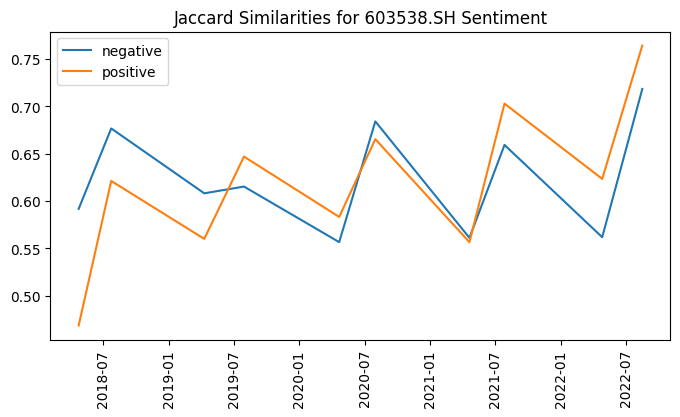

In [20]:
plot_similarities(
    [jaccard_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

As you can see the poor emotional consistency close 2022-04, At that time , this stock got plummeted

### TFIDF
using the sentiment word lists, let's generate sentiment TFIDF from the 10-k documents. Implement `get_tfidf` to generate TFIDF from each document, using sentiment words as the terms. You can ignore words that are not in `sentiment_words`.


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word split by space.
    """
    tfidf = TfidfVectorizer(vocabulary=sentiment_words)
    X = tfidf.fit_transform(docs)
    return X.toarray()

In [23]:
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}
    
print_ten_k_data([sentiment_tfidf_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]\n ...\n [0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]]'
    positive: '[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]\n ...\n [0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]]'},
]


### Cosine Similarity
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement `get_cosine_similarity` to return the cosine similarities between each tick in time. Since the input, `tfidf_matrix`, is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each neighboring vector.

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word of vector(tf-idf).

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    cosine_similarities = []
    for i in range(len(tfidf_matrix)-1):
        cosine_similarities.append(cosine_similarity([tfidf_matrix[i]], [tfidf_matrix[i+1]])[0][0])
    return cosine_similarities

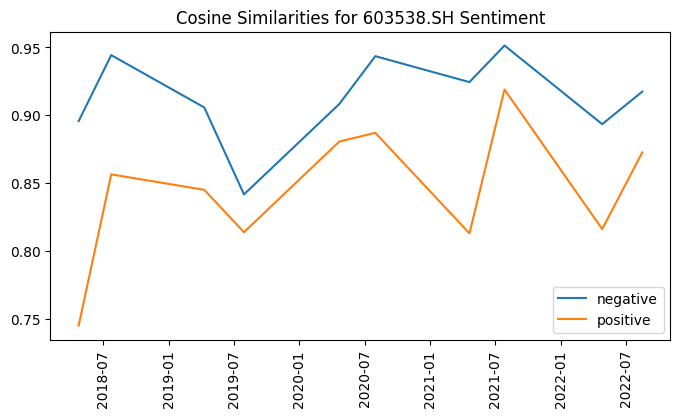

In [25]:
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


plot_similarities(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

### check another ticker similarity

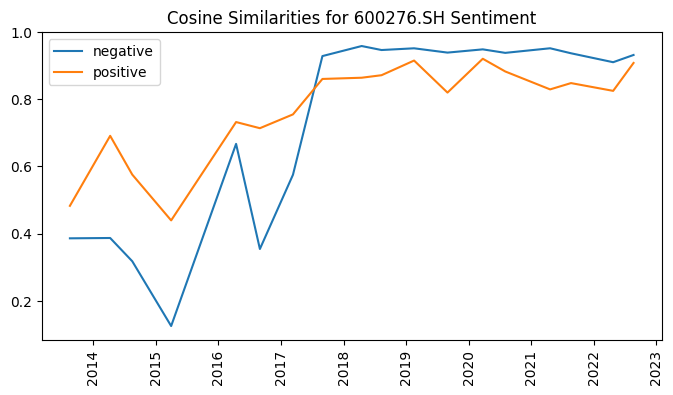

In [28]:
example_ticker = '600276.SH'
plot_similarities(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

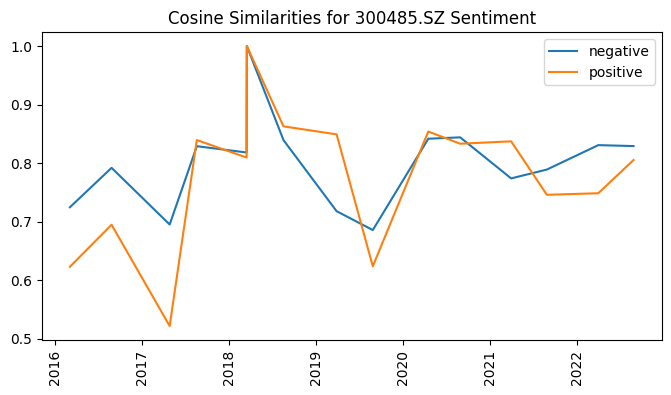

In [190]:
example_ticker = '300485.SZ'
plot_similarities(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

## Evaluate Alpha Factors
Just like we did in last project, let's evaluate the alpha factors. For this section, we'll just be looking at the cosine similarities, but it can be applied to the jaccard similarities as well.
### Price Data
Let's get half-year pricing to run the factor against, since our reports are produced half annually.

In [109]:
pricing = pd.read_csv('p5_month_price.csv',parse_dates=['trade_date']).iloc[:,1:]

# convert date to standard string format, easy to filter
pricing["date"] = pd.to_datetime(pricing["trade_date"], format='%Y%m%d')
pricing["date"] = pricing.trade_date.apply(lambda x: x.strftime("%Y-%m-%d"))
pricing = pricing.sort_values(by=["date", "ts_code"]).reset_index(drop=True)
pricing['date'] = pd.to_datetime(pricing['date'])
pricing = pricing.pivot(index='date', columns='ts_code', values='close')
pricing

ts_code,000756.SZ,300016.SZ,300347.SZ,300485.SZ,300723.SZ,600276.SH,603538.SH,688117.SH,688799.SH
date,,,,,,,,,
2013-01-31,3.3323,4.9158,4.6574,NaN,NaN,6.2646,NaN,NaN,NaN
2013-02-28,3.4475,5.3763,5.1883,NaN,NaN,6.3222,NaN,NaN,NaN
2013-03-29,3.8289,5.5330,6.6032,NaN,NaN,6.4488,NaN,NaN,NaN
2013-04-26,3.3179,4.7622,8.0982,NaN,NaN,5.8483,NaN,NaN,NaN
2013-05-31,3.6562,5.3203,8.2194,NaN,NaN,6.0133,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-09-30,18.0100,6.4300,91.1800,10.91,23.61,35.1000,23.76,22.62,31.48
2022-10-31,17.9100,6.9100,83.3500,11.77,27.65,40.2000,24.73,23.78,35.29
2022-11-30,22.7500,7.1000,88.6000,12.85,35.74,39.8300,28.01,24.99,34.00


### Dict to DataFrame
The alphalens library uses dataframes, so we we'll need to turn our dictionary into a dataframe. 

In [110]:
# cosine_similarities = {ticker:{positive:[],negtive:[]...}}
cosine_similarities_df_dict = {'date': [], 'ticker': [], 'sentiment': [], 'value': []}

for ticker, ten_k_sentiments in cosine_similarities.items():
    for sentiment_name, sentiment_values in ten_k_sentiments.items():
        for sentiment_values, sentiment_value in enumerate(sentiment_values):
            cosine_similarities_df_dict['ticker'].append(ticker)
            cosine_similarities_df_dict['sentiment'].append(sentiment_name)
            cosine_similarities_df_dict['value'].append(sentiment_value)
            cosine_similarities_df_dict['date'].append(file_dates[ticker][1:][sentiment_values])

cosine_similarities_df = pd.DataFrame(cosine_similarities_df_dict)

cosine_similarities_df["date"] = cosine_similarities_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
cosine_similarities_df = cosine_similarities_df.sort_values(by=["date", "ticker"]).reset_index(drop=True)
cosine_similarities_df['date'] = pd.to_datetime(cosine_similarities_df['date'])
cosine_similarities_df.head()

,date,ticker,sentiment,value
0,2013-07-31,300016.SZ,negative,0.348862
1,2013-07-31,300016.SZ,positive,0.614005
2,2013-08-17,600276.SH,negative,0.385954
3,2013-08-17,600276.SH,positive,0.482680
4,2014-03-31,000756.SZ,negative,0.938192


Transport alpha df index(date) correspond to price df index(date). 

In [131]:
def pivot_by_sentiment(sentiment):
    factor_df = pd.DataFrame(index=pricing.index)
    tmp_df = cosine_similarities_df[(cosine_similarities_df['sentiment'] == sentiment)]
    tmp_df = tmp_df.pivot(index='date', columns='ticker', values='value')
    factor_df = factor_df.merge(tmp_df, on=["date"], how="outer")
    factor_df.fillna(method='ffill', inplace=True)
    factor_df.fillna(method='bfill', inplace=True)
    factor_df = factor_df.loc[factor_df.index.isin(pricing.index)]
    return factor_df
cs_df = pivot_by_sentiment('positive')
cs_df

,000756.SZ,300016.SZ,300347.SZ,300485.SZ,300723.SZ,600276.SH,603538.SH,688117.SH,688799.SH
date,,,,,,,,,
2013-01-31,0.821537,0.614005,0.986401,0.748388,0.878316,0.439307,0.887027,0.904468,0.912405
2013-02-28,0.821537,0.614005,0.986401,0.748388,0.878316,0.439307,0.887027,0.904468,0.912405
2013-03-29,0.821537,0.614005,0.986401,0.748388,0.878316,0.439307,0.887027,0.904468,0.912405
2013-04-26,0.821537,0.614005,0.986401,0.748388,0.878316,0.439307,0.887027,0.904468,0.912405
2013-05-31,0.821537,0.614005,0.986401,0.748388,0.878316,0.439307,0.887027,0.904468,0.912405
...,...,...,...,...,...,...,...,...,...
2022-09-30,0.908594,0.802452,0.986401,0.748388,0.915742,0.819857,0.887027,0.904468,0.912405
2022-10-31,0.908594,0.802452,0.986401,0.748388,0.915742,0.819857,0.887027,0.904468,0.912405
2022-11-30,0.908594,0.802452,0.986401,0.748388,0.915742,0.819857,0.887027,0.904468,0.912405


### Alphalens Format
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. In this next cell, we'll do just that.

In [187]:
import alphalens as al
from copy import deepcopy

factor_data = {}
skipped_sentiments = []

for sentiment in sentiments:
    cs_df = pivot_by_sentiment(sentiment)
#    try:
    data = al.utils.get_clean_factor_and_forward_returns(cs_df.stack(), pricing, quantiles=5, periods=[1,3])
    factor_data[sentiment] = deepcopy(data)
#     except:
#         skipped_sentiments.append(sentiment)

if skipped_sentiments:
    print('\nSkipped the following sentiments:\n{}'.format('\n'.join(skipped_sentiments)))
factor_data[sentiments[0]].head()

Dropped 33.8% entries from factor data: 33.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 33.8% entries from factor data: 33.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        3D    factor  factor_quantile
date       asset                                                   
2013-01-31 000756.SZ  0.034571 -0.004321  0.938192                4
           300016.SZ  0.093678 -0.031246  0.348862                2
           300347.SZ  0.113991  0.738781  0.980326                5
           600276.SH  0.009195 -0.066453  0.124828                1
2013-02-28 000756.SZ  0.110631  0.060537  0.938192                4

In [172]:
unixt_factor_data = {
    factor: data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in data.index.values],
        names=['date', 'asset']))
    for factor, data in factor_data.items()}

### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

<AxesSubplot:title={'center':'quantile 3D'}, xlabel='date'>

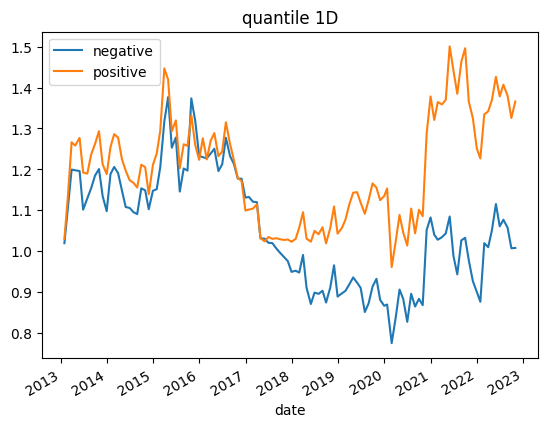

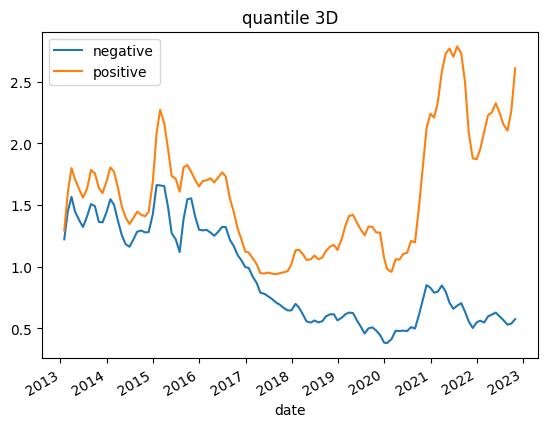

In [173]:
ls_factor_returns_1day = pd.DataFrame()
ls_factor_returns_3day = pd.DataFrame()

for factor, factor_data in factor_data.items():
    al_factor_returns = al.performance.factor_returns(factor_data)
    ls_factor_returns_1day[factor] = al_factor_returns.iloc[:, 0]
    ls_factor_returns_3day[factor] = al_factor_returns.iloc[:, 1]
    
(1+ls_factor_returns_1day).cumprod().plot(title='quantile 1D')
(1+ls_factor_returns_3day).cumprod().plot(title='quantile 3D')

### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

array([[<AxesSubplot:title={'center':'negative'}, xlabel='factor_quantile'>,
        <AxesSubplot:title={'center':'positive'}, xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>],
       [<AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>],
       [<AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>],
       [<AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>],
       [<AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>]], dtype=object)

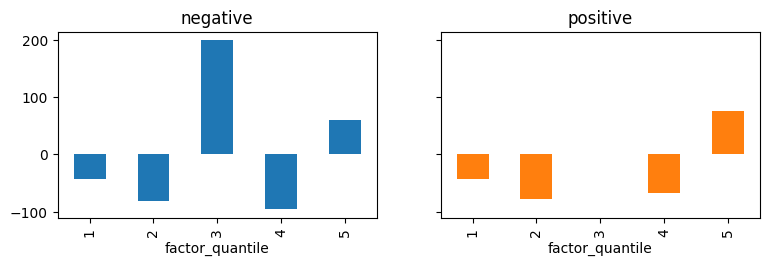

In [174]:
qr_factor_returns = pd.DataFrame()

for factor_name, data in unixt_factor_data.items():
    qr_factor_returns[factor_name] = al.performance.mean_return_by_quantile(data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,3),
    figsize=(14, 14),
    legend=False)

array([[<AxesSubplot:title={'center':'negative'}, xlabel='factor_quantile'>,
        <AxesSubplot:title={'center':'positive'}, xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>],
       [<AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>],
       [<AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>],
       [<AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>],
       [<AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>]], dtype=object)

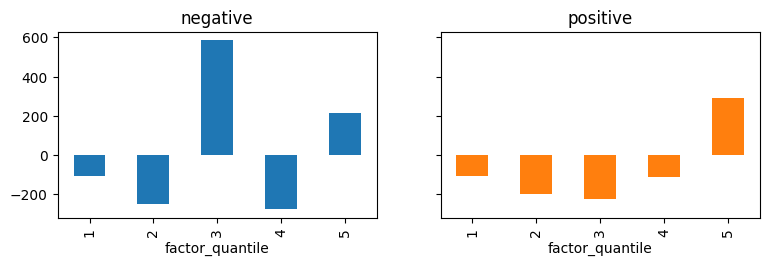

In [175]:
qr_factor_returns = pd.DataFrame()

for factor_name, data in unixt_factor_data.items():
    qr_factor_returns[factor_name] = al.performance.mean_return_by_quantile(data)[0].iloc[:, 1]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,3),
    figsize=(14, 14),
    legend=False)

### Turnover Analysis
Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **Factor Rank Autocorrelation (FRA)**.

<AxesSubplot:title={'center':'Factor Rank Autocorrelation'}, xlabel='date'>

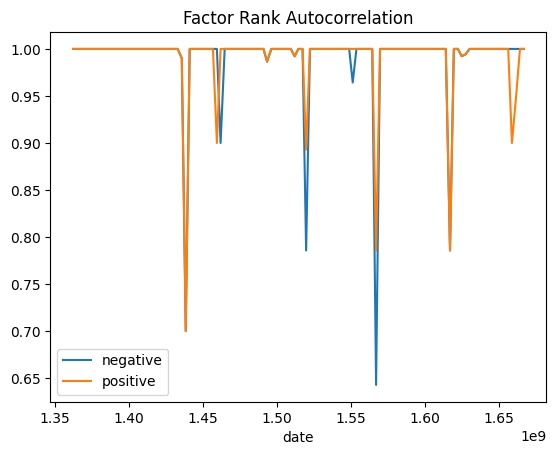

In [176]:
ls_FRA = pd.DataFrame()

for factor, data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

In [179]:
daily_annualization_factor = np.sqrt(252)

(daily_annualization_factor * ls_factor_returns_1day.mean() / ls_factor_returns_1day.std()).round(2)

negative    0.41
positive    1.24
dtype: float64

In [180]:
daily_annualization_factor = np.sqrt(252)

(daily_annualization_factor * ls_factor_returns_3day.mean() / ls_factor_returns_3day.std()).round(2)

negative   -0.36
positive    2.23
dtype: float64

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.439307,0.802452,0.606340,0.157329,185,25.658807
2,0.487850,0.887027,0.733545,0.097908,134,18.585298
3,0.702771,0.904468,0.804469,0.059576,90,12.482663
4,0.748388,0.912405,0.850775,0.052558,134,18.585298
5,0.887027,0.986401,0.955359,0.044181,178,24.687933


Returns Analysis


,1D,3D
Ann. alpha,0.219,0.228
beta,0.135,0.131
Mean Period Wise Return Top Quantile (bps),75.251,96.160
Mean Period Wise Return Bottom Quantile (bps),-43.079,-35.937
Mean Period Wise Spread (bps),118.330,133.208


<Figure size 640x480 with 0 Axes>

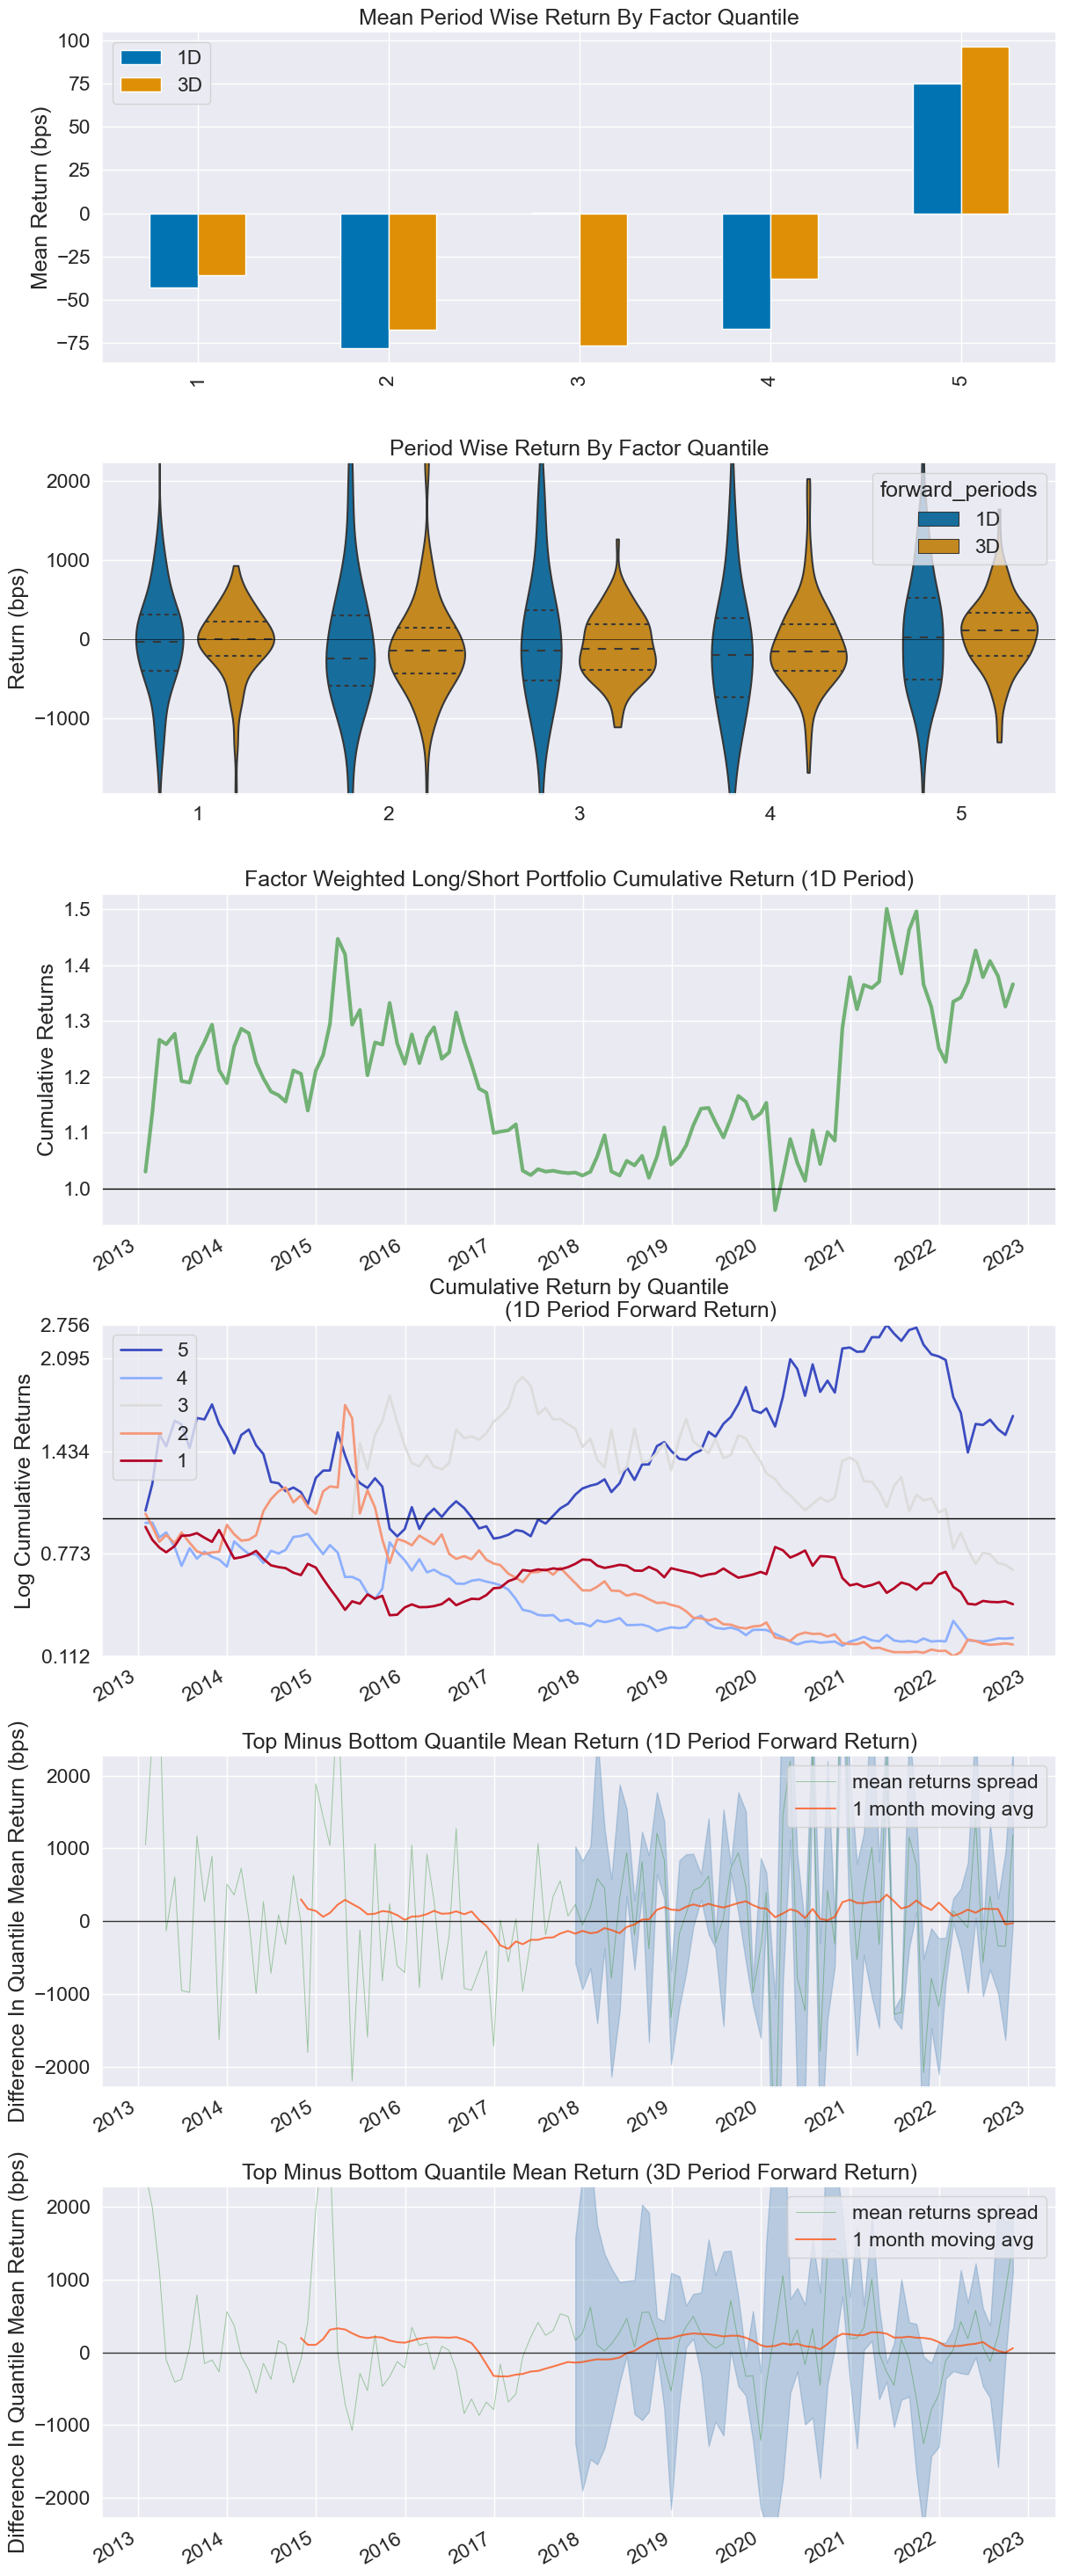

Information Analysis


,1D,3D
IC Mean,-0.003,0.013
IC Std.,0.449,0.420
Risk-Adjusted IC,-0.007,0.030
t-stat(IC),-0.080,0.331
p-value(IC),0.937,0.742
IC Skew,-0.014,0.077
IC Kurtosis,-0.515,-0.425


/Users/jiaruiming/anaconda/envs/py37/lib/python3.7/site-packages/alphalens/plotting.py:276: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ic.replace(np.nan, 0.), norm_hist=True, ax=a)
/Users/jiaruiming/anaconda/envs/py37/lib/python3.7/site-packages/alphalens/plotting.py:276: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad63727

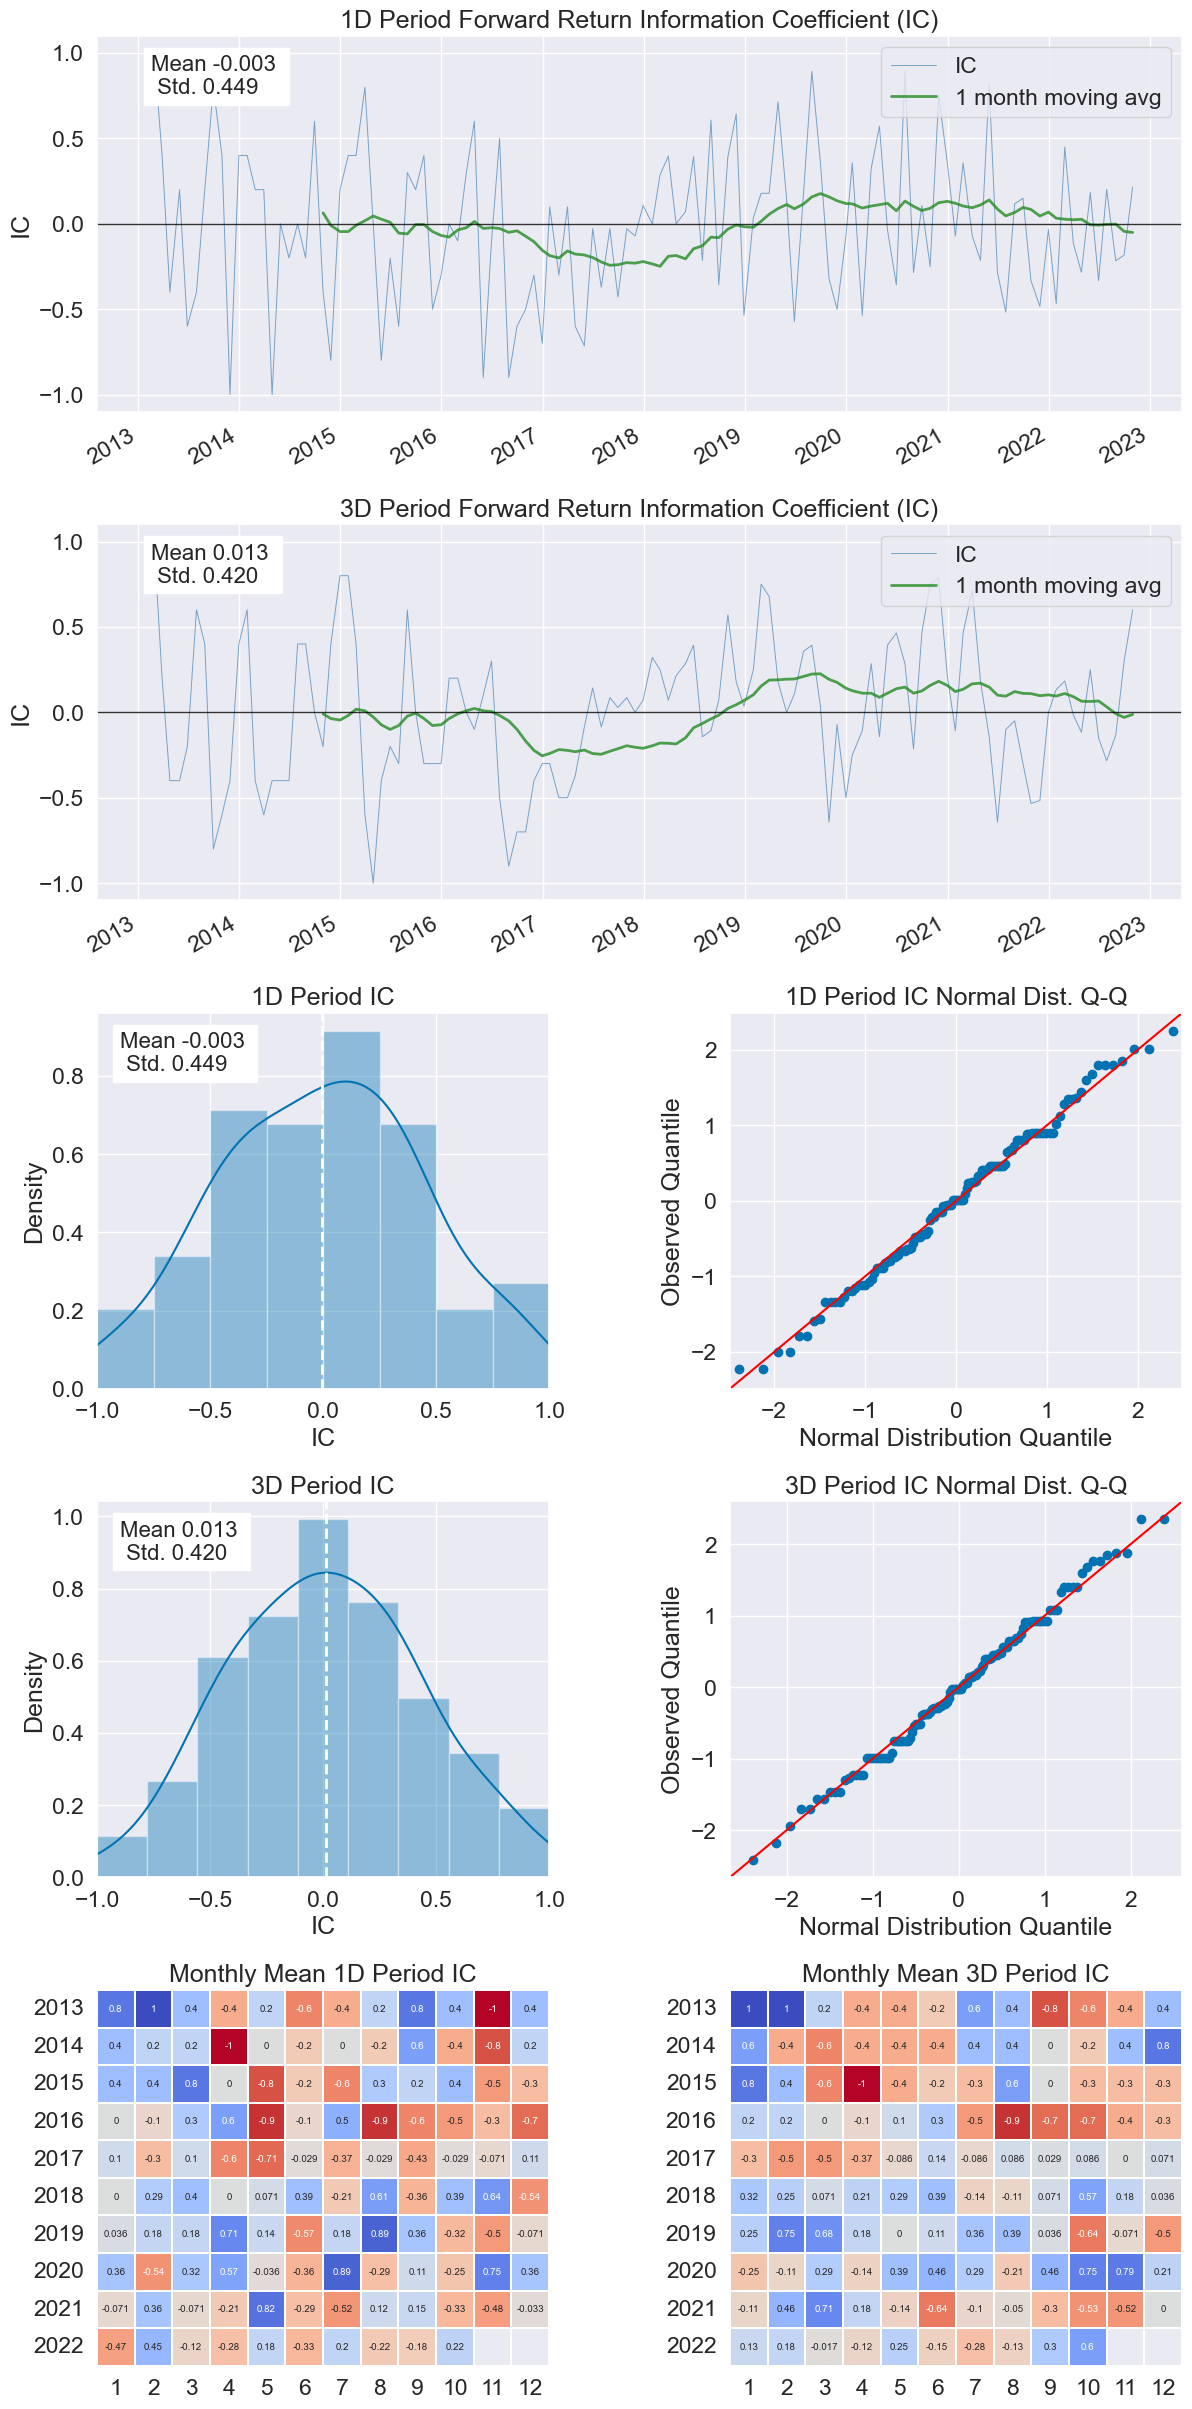

/Users/jiaruiming/anaconda/envs/py37/lib/python3.7/site-packages/alphalens/utils.py:911: UserWarning: Skipping return periods that aren't exact multiples of days.
  "Skipping return periods that aren't exact multiples"


Turnover Analysis


,1D,3D
Quantile 1 Mean Turnover,0.017,0.052
Quantile 2 Mean Turnover,0.060,0.183
Quantile 3 Mean Turnover,0.097,0.262
Quantile 4 Mean Turnover,0.047,0.135
Quantile 5 Mean Turnover,0.017,0.043


,1D,3D
Mean Factor Rank Autocorrelation,0.99,0.972


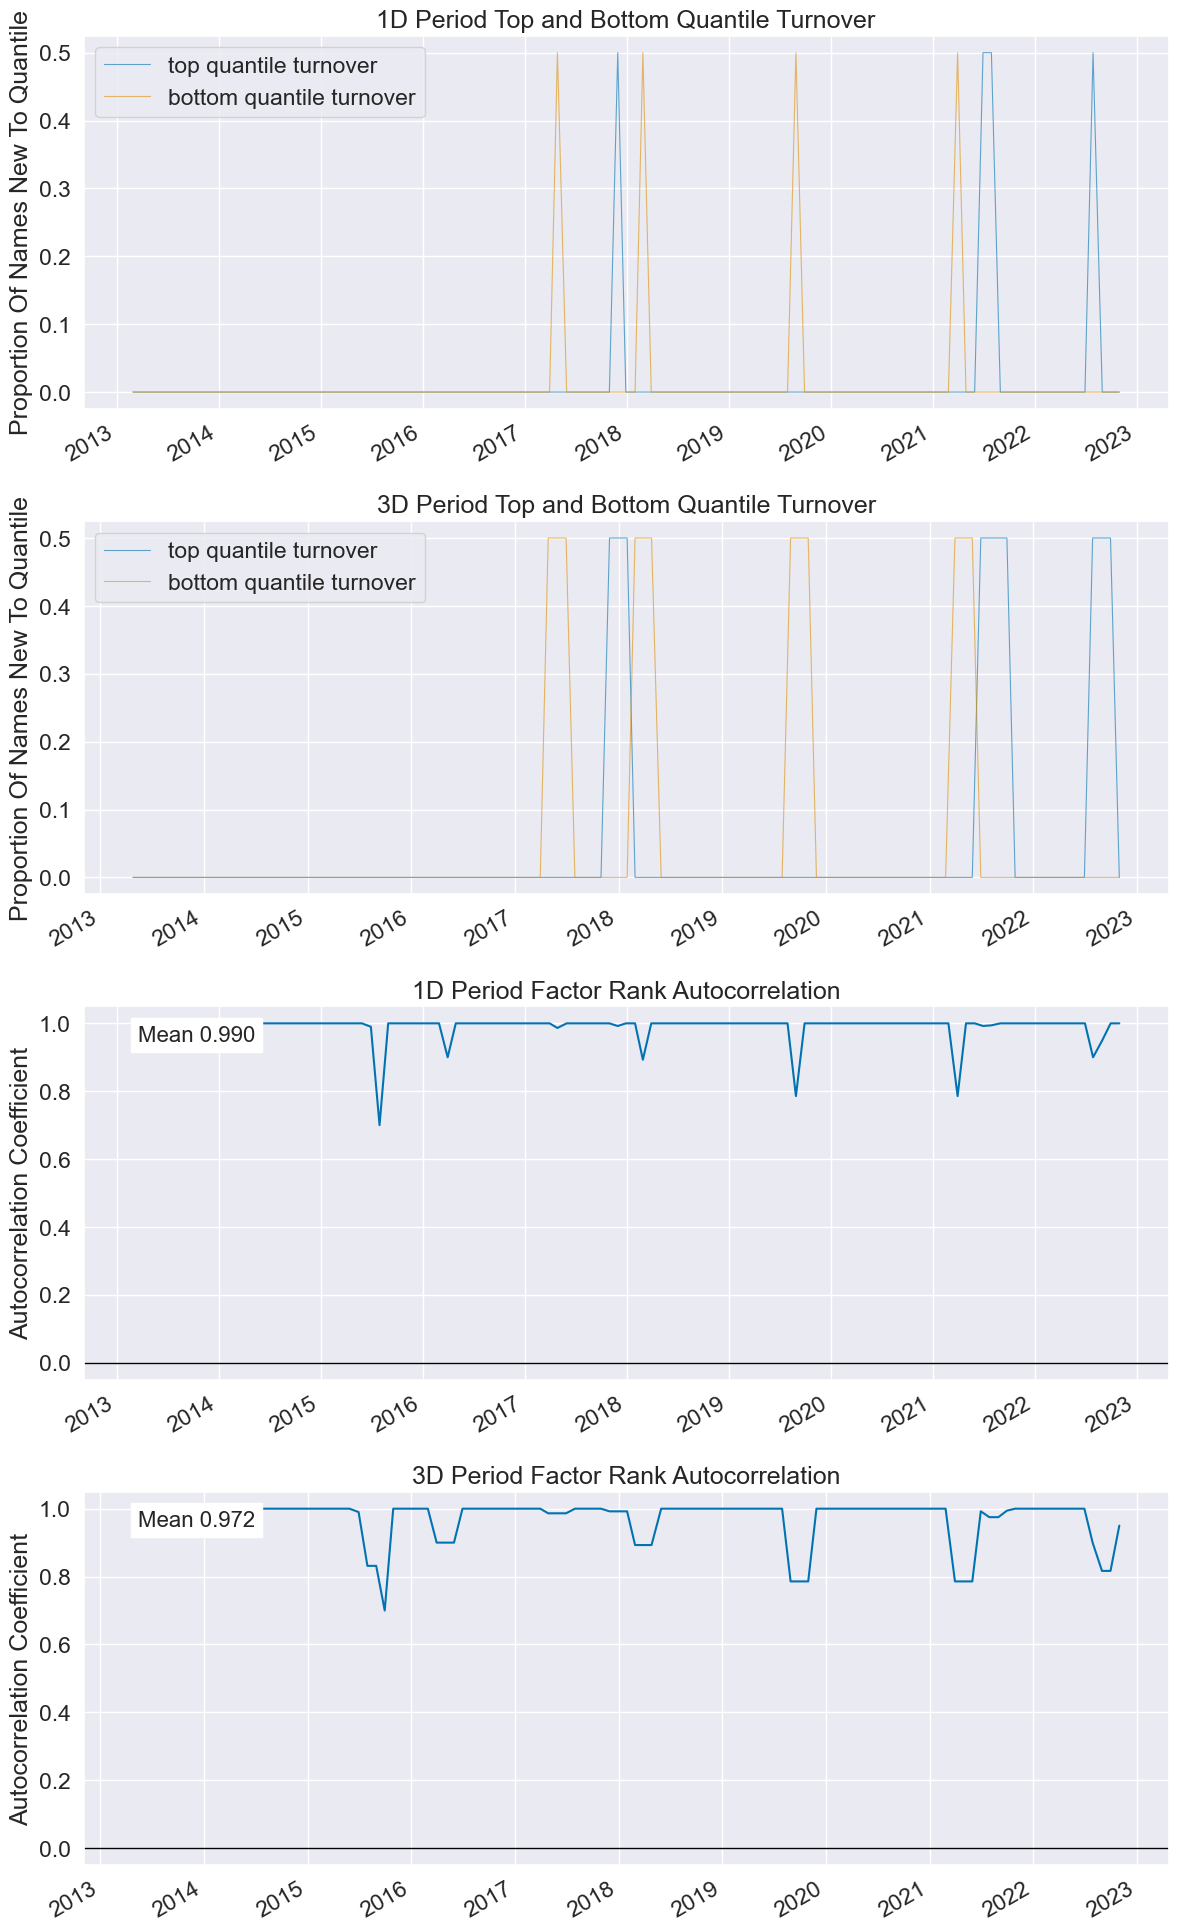

In [188]:
al.tears.create_full_tear_sheet(factor_data['positive'])